# Project 2: Continuous Control

## The environment

In this project we will train the Reacher Unity environment. The goal of your agent is to maintain its position at the target location for as many time steps as possible.


- __Set-up__: Double-jointed arm which can move to target locations.
- __Goal__: The agents must move its hand to the goal location, and keep it there.
- __Agent Reward__: +0.1 Each step agent's hand is in goal location.

The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector should be a number between -1 and 1.

<img src="https://video.udacity-data.com/topher/2018/June/5b1ea778_reacher/reacher.gif">

Intsall Environments to Udacity's Workspace. This has been provided in the Workspace itself.

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


## Start the Envirtonment

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# 1 AGENT environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# 20 AGENTS environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# Reset the environment
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

print('Number of agents:', num_agents)
print('Size of each action:', action_size)
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
# print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33


## Model

- __Actor__ - Get action from state 

- __Critic__ - DQN using actors actions. That is, the Critic is a function approximation of the Q value for a given state-action. To be used as a baseline for the actor to reduce bias (varianse?)

In [5]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.bn0 = nn.BatchNorm1d(state_size)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        
        x = self.bn0(state)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.bn0 = nn.BatchNorm1d(state_size)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        
        state = self.bn0(state)
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [6]:
print(Actor(33, 4, 0))
print(Critic(33, 4, 0))

Actor(
  (bn0): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=33, out_features=400, bias=True)
  (bn1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (bn2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=300, out_features=4, bias=True)
)
Critic(
  (bn0): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fcs1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=404, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


## Agent

In [7]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e6)  ## replay buffer size
BATCH_SIZE = 256       ## minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor  ## ?
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

EPSILON = 1.0           # noise factor
EPSILON_DECAY = 1e-6    # decay of noise factor

LEARN_EVERY = 20        # learning timestep interval
LEARN_NUM   = 10        # number of learning passes
GRAD_CLIPPING = 1.0     # Gradient Clipping


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.epsilon = EPSILON
        # EPSILON ?

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        
        ##### hard update ?
    
    def step(self, states, actions, rewards, next_states, dones, timestep):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        
        # TAKES states from agents
        # state receives state instead of states
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)
                
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory + LEARN_EVERY
#         if len(self.memory) > BATCH_SIZE  and timestep % LEARN_EVERY == 0:
#             for _ in range(LEARN_NUM):
#                 experiences = self.memory.sample()
#                 self.learn(experiences, GAMMA)
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.epsilon * self.noise.sample()
        return np.clip(action, -1, 1)  # why clip?

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss + GRAD CLIPPING
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)         
        
        # eps decay # noise reset?
        # --------------------- and update epsilon decay ----------------------- #
        if EPSILON_DECAY > 0:
            self.epsilon -= EPSILON_DECAY
            self.noise.reset()

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## DDPG algorithm

In [52]:
def ddpg(n_episodes=2000, print_every=10):
    scores_deque = deque(maxlen=100)
    scores_global = []
    moving_avgs = []

    for i_episode in range(1, n_episodes+1):

        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment 
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)

        agent.reset()
        score_average = 0

        for t in count():
            actions = agent.act(states)                        # get actions           
            actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            
            # Step agent
            agent.step(states, actions, rewards, next_states, dones, t)

            states = next_states                               # roll over states to next time step
            scores += env_info.rewards                         # update the score (for each agent) 
            if np.any(dones):                                  # exit loop if episode finished
                break

        score = np.mean(scores)
        scores_deque.append(score)
        score_average = np.mean(scores_deque)
        scores_global.append(score)
        moving_avgs.append(score_average)

        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, score_average))
        elif score_average >= 30:
            print('\rEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode, score_average)
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
        else:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, score_average), end="")
        
    return scores_global, moving_avgs


# Train Agent

In [55]:
# Init Agent
agent = Agent(state_size = state_size, action_size = action_size, random_seed = 111)

# Train
n_episodes = 200
scores, avgs = ddpg(n_episodes = n_episodes)

Episode 10	Average Score: 0.31
Episode 20	Average Score: 0.87
Episode 30	Average Score: 1.54
Episode 40	Average Score: 2.39
Episode 50	Average Score: 3.68
Episode 60	Average Score: 5.89
Episode 70	Average Score: 8.85
Episode 80	Average Score: 11.96
Episode 90	Average Score: 14.75
Episode 100	Average Score: 17.10
Episode 110	Average Score: 20.85
Episode 120	Average Score: 24.23
Episode 130	Average Score: 27.58
Episode 137	Average Score: 29.81

IndexError: tuple index out of range

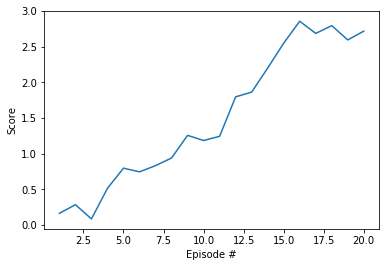

In [54]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='Moving AVG')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()